In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl 
import numpy.random as npr
from scipy.optimize import minimize
# from process_results import process_results, aggregate_results, best_ridge
from scipy.stats import ortho_group
from sklearn.linear_model import LinearRegression, RidgeCV
import scipy.linalg as scl
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


In [42]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

In [13]:
cs=sns.color_palette()

## MDL COMP FOR different eigenvalues decay of Matrices

In [8]:
def loc_calc_thetahat(l):
    inv = scl.pinv(X_train_d.T @ X_train_d + l * np.eye(d))
#     inv = eigenvecs @ npl.pinv(np.eye(d) + np.diag(eigenvals)) @ eigenvecs.T
    return inv @ X_train_d.T @ y_train_n

def loc_mdl1_loss(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return (mse_norm + theta_norm + eigensum) / n


def loc_mdl1_loss_ret_all(l):
    thetahat = loc_calc_thetahat(l)
    mse_norm = npl.norm(y_train_n - X_train_d @ thetahat)**2 / (2 * var)
    theta_norm = npl.norm(thetahat)**2 / (2 * var)
    eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
    return mse_norm/n , theta_norm/n,  eigensum / n

def g(a, b):
    val = np.sqrt(a*(1+np.sqrt(b))**2+1)
    val -= np.sqrt(a*(1-np.sqrt(b))**2+1)
    val = val**2
    return(val/4)

def thm3(gammas, snr):
    delta = g(snr, gammas)
    bnd = gammas * np.log(1+snr-delta)
    bnd += np.log(1+gammas * snr - delta)
    bnd -= delta/snr
    return(bnd)

In [ ]:
mdl_practice = np.zeros((num_trials,  len(ds), len(ns)))
mdl_rmt = np.zeros((num_trials,  len(ds), len(ns)))
mdl_theory = np.zeros((num_trials, len(ds), len(ns)))
# mdl_theory_mean = np.zeros((num_trials, len(ds), len(ns)))
# mdl_theory_lam  = np.zeros((num_trials, len(ds), len(ns)))
mse = np.zeros((num_trials, len(ds), len(ns)))
tnorm = np.zeros((num_trials, len(ds), len(ns)))
eigsum = np.zeros((num_trials, len(ds), len(ns)))
mse_test = np.zeros((num_trials, len(ds), len(ns)))

for j, d in enumerate(ds):
    ns = np.asarray(d/gammas, dtype=int)
    for k, n in enumerate(ns):
        print(d, n)
        X_train = npr.randn(n, d) / np.sqrt(n)
        X_test = npr.randn(n_test, d)
        eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
        
        for i in tqdm(range(num_trials)):
            
            beta_star = npr.randn(d)
            beta_star /= npl.norm(beta_star)    
            beta_star *= 1. #

            w = eigenvecs.T  @ beta_star
            
            y_train = X_train @ beta_star + noise_std * npr.randn(n)
            y_test =  X_test @ beta_star # + noise_std *  npr.randn(n_test)

            
            opt_solved = minimize(loc_mdl1_loss, x0=1e-10)
            lambda_opt = opt_solved.x
            
            mdl_practice[i, j, k] = opt_solved.fun
            mdl_theory[i, j, k] = np.sum(np.log(1+ eigenvals * w**2 / var)) / n
            mdl_theory_mean[i, j, k] = np.sum(np.log(1+ eigenvals * np.mean(w**2) /var)) / n
            mdl_theory_lam[i, j, k] = np.sum(np.log(1+ eigenvals / lambda_opt)) / n
            mse[i, j, k], tnorm[i, j, k], eigsum[i, j, k] = loc_mdl1_loss_ret_all(lambda_opt)
            
            mse_test[i, j, k] = npl.norm(y_test- X_test @ loc_calc_thetahat(lambda_opt))**2 / n_test





  0%|          | 0/2 [00:00<?, ?it/s]




0it [00:00, ?it/s]




1it [00:00,  5.96it/s]

0 0 2 100 50 0.0
0 0 2 100 200 0.0
0 0 10 100 50 0.0







2it [00:00,  5.55it/s]

0 0 10 100 200 0.0
0 0 20 100 50 0.0







3it [00:00,  4.53it/s]

0 0 20 100 200 0.0
0 0 50 100 50 0.0
0 0 50 100 200 0.0







4it [00:01,  2.43it/s]

0 0 100 100 50 0.0
0 0 100 100 200 0.0







5it [00:04,  1.10s/it]

0 0 200 100 50 0.0
0 0 200 100 200 0.0







6it [00:12,  3.15s/it]

0 0 400 100 50 0.0
0 0 400 100 200 0.0







7it [00:58, 16.12s/it]

0 0 800 100 50 0.0
0 0 800 100 200 0.0







8it [05:04, 85.20s/it]

0 0 1000 100 50 0.0
0 0 1000 100 200 0.0







9it [12:29, 192.91s/it]



 50%|█████     | 1/2 [12:29<12:29, 749.25s/it]




0it [00:00, ?it/s]




1it [00:00,  6.23it/s]

1 0 2 100 50 0.0
1 0 2 100 200 0.0
1 0 10 100 50 0.0







2it [00:00,  5.61it/s]

1 0 10 100 200 0.0
1 0 20 100 50 0.0







3it [00:00,  4.63it/s]

1 0 20 100 200 0.0
1 0 50 100 50 0.0
1 0 50 100 200 0.0







4it [00:01,  2.46it/s]

1 0 100 100 50 0.0
1 0 100 100 200 0.0







5it [00:04,  1.06s/it]

1 0 200 100 50 0.0
1 0 200 100 200 0.0







6it [00:12,  3.12s/it]

1 0 400 100 50 0.0
1 0 400 100 200 0.0







7it [00:53, 14.56s/it]

1 0 800 100 50 0.0
1 0 800 100 200 0.0







8it [04:56, 83.10s/it]

1 0 1000 100 50 0.0
1 0 1000 100 200 0.0







9it [12:24, 192.62s/it]



100%|██████████| 2/2 [24:53<00:00, 747.84s/it]

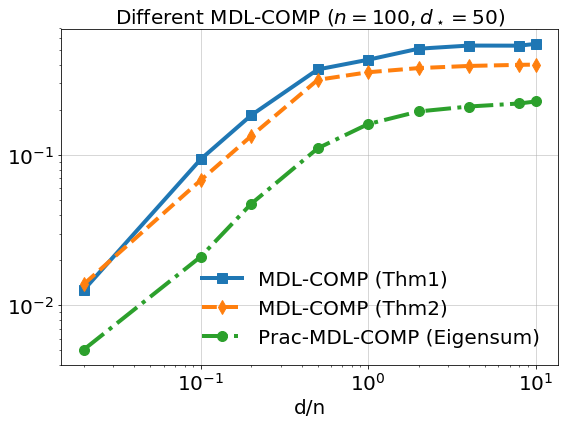

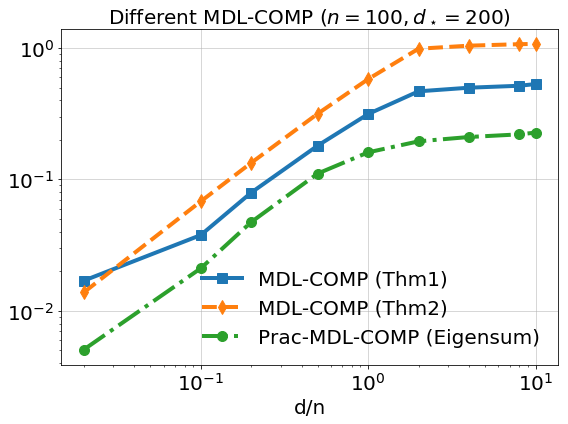





  0%|          | 0/2 [00:00<?, ?it/s]




0it [00:00, ?it/s]




1it [00:00,  6.13it/s]

0 0 2 100 50 0.0
0 0 2 100 200 0.0
0 0 10 100 50 0.0







2it [00:00,  5.70it/s]

0 0 10 100 200 0.0
0 0 20 100 50 0.0







3it [00:00,  4.54it/s]

0 0 20 100 200 0.0
0 0 50 100 50 0.0
0 0 50 100 200 0.0







4it [00:01,  2.44it/s]

0 0 100 100 50 0.0
0 0 100 100 200 0.0







5it [00:04,  1.08s/it]

0 0 200 100 50 0.0
0 0 200 100 200 0.0







6it [00:12,  3.17s/it]

0 0 400 100 50 0.0
0 0 400 100 200 0.0







7it [00:58, 16.13s/it]

0 0 800 100 50 0.0
0 0 800 100 200 0.0







8it [05:10, 86.77s/it]

0 0 1000 100 50 0.0
0 0 1000 100 200 0.0







9it [12:28, 192.24s/it]



 50%|█████     | 1/2 [12:28<12:28, 748.57s/it]




0it [00:00, ?it/s]




1it [00:00,  6.13it/s]

1 0 2 100 50 0.0
1 0 2 100 200 0.0
1 0 10 100 50 0.0







2it [00:00,  5.66it/s]

1 0 10 100 200 0.0
1 0 20 100 50 0.0







3it [00:00,  4.47it/s]

1 0 20 100 200 0.0
1 0 50 100 50 0.0
1 0 50 100 200 0.0







4it [00:01,  2.47it/s]

1 0 100 100 50 0.0
1 0 100 100 200 0.0







5it [00:04,  1.03s/it]

1 0 200 100 50 0.0
1 0 200 100 200 0.0







6it [00:12,  3.15s/it]

1 0 400 100 50 0.0
1 0 400 100 200 0.0







7it [00:53, 14.53s/it]

1 0 800 100 50 0.0
1 0 800 100 200 0.0







8it [04:51, 81.55s/it]

1 0 1000 100 50 0.0
1 0 1000 100 200 0.0







9it [11:59, 185.55s/it]



100%|██████████| 2/2 [24:27<00:00, 739.82s/it]

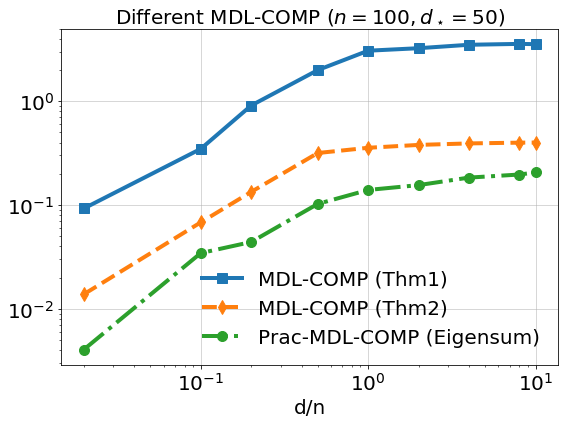

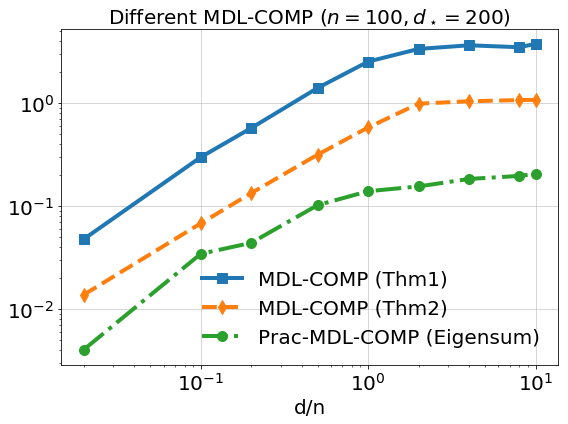

In [53]:
save_data = True

npr.seed(9834982)

for noise_std in [1., 0.1]:
    var = noise_std**2

    d0s = np.array([50, 200], dtype=int)
    ds = np.array([2, 10, 20, 50, 100, 200, 400, 800, 1000])
    ns = np.array([100])
    epows = [0.]

    num_norms = 1
    num_trials = 2

    prac_mdl_comp = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows))) 
    mse = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows))) 
    tnorm = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows))) 
    eigsum = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows))) 


    rmt_mdl_comp = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
    rmt_mdl_comp_2 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))
    rmt_mdl_comp_3 = np.zeros((num_trials, num_norms, len(ds), len(ns), len(d0s), len(epows)))


    new_rmt_mdl_comp = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
    new_rmt_mdl_comp_2 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))
    new_rmt_mdl_comp_3 = np.zeros((num_trials,num_norms, len(ds), len(ns), len(d0s), len(epows)))

    dmax = max(ds)

    beta_stars = np.zeros((len(d0s), dmax))
    # initialize beta_Star fixed
    for l, d0 in enumerate(d0s):
        beta_fixed = npr.randn(d0)
        beta_fixed /= npl.norm(beta_fixed)
        beta_stars[l, :d0] = beta_fixed


    for m in tqdm(range(num_trials)):

        noise = noise_std * npr.randn(max(ns))
        # change X_train
        for p, epow in enumerate(epows):

            eigs = np.diag(np.arange(1, dmax+1)**(-epow))
            X_train = npr.randn(max(ns), dmax) @ eigs

            y_train_stars = np.zeros((len(d0s), ns[0]))
            y_train  = np.zeros((len(d0s), ns[0]))

            for ltemp, d0 in enumerate(d0s):
                y_train_stars[ltemp, :] = X_train[:, :d0] @ beta_stars[ltemp, :d0]

            for j, d in tqdm(enumerate(ds)):
                for k, n in enumerate(ns):
                    X_train_d = X_train[:n, :d]

                    eigenvals, eigenvecs = scl.eigh(X_train_d.T @ X_train_d)
                    eigenvals = eigenvals[::-1]
                    V, s, Uh = scl.svd(X_train_d, full_matrices=False)

                    for l, d0 in enumerate(d0s):

                        w = eigenvecs.T @ beta_stars[l, :d]
                        w = w[::-1] # arrange in order

                        v = V.T @ y_train_stars[l, :]

                        for i in range(num_norms):

                            print(m, i, d, n, d0, epow)
                            f = (i+1)**2

                            y_train_n = f*y_train[l, :n] + noise[:n]
                            opt_solved = minimize(loc_mdl1_loss, x0=1e-10)
                            lambda_opt = opt_solved.x

                            prac_mdl_comp[m, i, j, k, l, p] = opt_solved.fun
                            mse[m, i, j, k, l, p], tnorm[m, i, j, k, l, p], eigsum[m, i, j, k, l, p] = loc_mdl1_loss_ret_all(lambda_opt)
                            rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 *eigenvals[:min(n, d)] * (w**2/ var)[:min(n, d)])) / n
                            rmt_mdl_comp_2[m, i, j, k, l, p]  = rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log((var / (f**2 * w**2))[:min(n, d)])) / n
                            rmt_mdl_comp_3[m, i, j, k, l, p] = rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) * min(n, d)/n


                            new_rmt_mdl_comp[m, i, j, k, l, p] = np.sum(np.log(1+f**2 * v**2/var)) / n
                            new_rmt_mdl_comp_2[m, i, j, k, l, p] = new_rmt_mdl_comp[m, i, j, k, l, p] + np.sum(np.log( var / (f**2 * v**2))) / n
                            new_rmt_mdl_comp_3[m, i, j, k, l, p] = new_rmt_mdl_comp_2[m, i, j, k, l, p] - np.log(0.005) *min(n, d)/n 
    if save_data:
        results = {'ns': ns, 'd0s': d0s,  'ds' : ds,
                   'epows': epows,
                   'num_trials': num_trials, 
                   'num_norms': num_norms,
                   'mse': mse,
                   'tnorm': tnorm,
                   'eigsum': eigsum,
                   'noise_var': noise_std**2,
                    'prac_mdl_comp': prac_mdl_comp,
                    'rmt_mdl_comp': rmt_mdl_comp,
                   'rmt_mdl_comp_2':rmt_mdl_comp_2,
                   'rmt_mdl_comp_3' : rmt_mdl_comp_3,
                   'new_rmt_mdl_comp': new_rmt_mdl_comp,
                   'new_rmt_mdl_comp_2': new_rmt_mdl_comp_2,
                   'new_rmt_mdl_comp_3': new_rmt_mdl_comp_3
                  }
        file = open(oj('intermediate', 
                       'prac_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std)), 'wb')
        pickle.dump(results, file)
        file.close()

    # results = pickle.load(oj('intermediate',
#         open('prac_mdl_n_%d_noise_%d.txt'%(ns[0], noise_std)), 'rb'))
    save_fig = True

    lss = ['-', '--', '-.', ':']
    mss = ['s', 'd', 'o', '^']
    n = ns[0]
    gammas = ds/n

    for i in range(1):
        for l, d0 in enumerate(d0s):
            plt.figure(figsize=[8, 6])

            plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, l, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label='MDL-COMP (Thm1)')
            plt.loglog(gammas, thm3(gammas, np.minimum(d0,ds)/ds),  color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1], markersize=10, label='MDL-COMP (Thm2)')
            plt.loglog(gammas, eigsum.mean(0)[i, :, 0, l, 0], color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2], markersize=10, label= 'Prac-MDL-COMP (Eigensum)')
            plt.grid(True, alpha=0.5, linewidth=1.)
    #         plt.ylim([1e-3, 8e-1])
            plt.legend(frameon=False, fontsize=20) 
            plt.title(r'Different MDL-COMP ($n=%d, d_\star=%d$)'%(ns[0], d0), fontsize=20)
            plt.xlabel('d/n')
            plt.tight_layout()
            plt.savefig('fig3/prac_mdl_comp_norm_%d_n_%d_noise_%d_d0_%d.pdf'%((i+1)**2, n, noise_std, d0))
            plt.show()

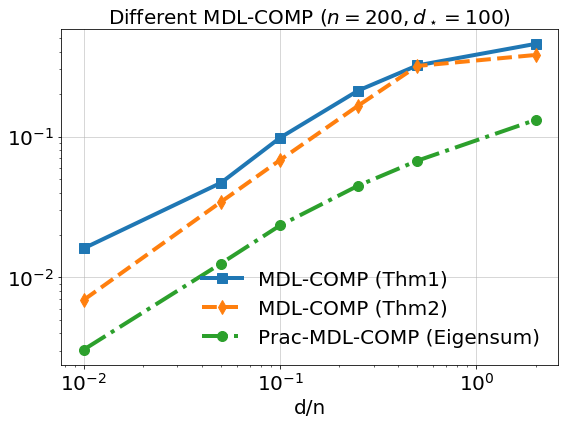

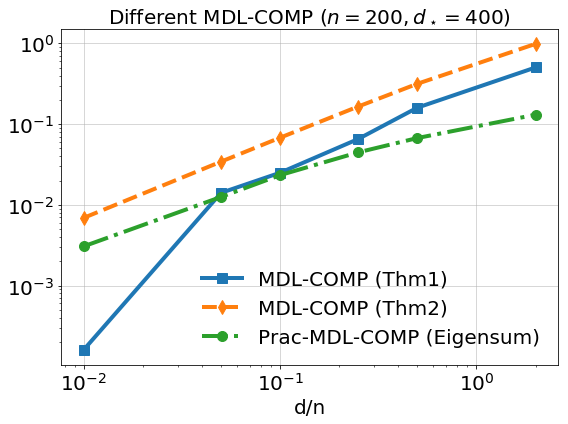

In [51]:
for i in range(1):
    for l, d0 in enumerate(d0s):
        plt.figure(figsize=[8, 6])

        plt.loglog(gammas, rmt_mdl_comp.mean(0)[i, :, 0, l, 0],   color=cs[0], linestyle=lss[0], linewidth=4.,  marker=mss[0],  markersize=10, label='MDL-COMP (Thm1)')
        plt.loglog(gammas, thm3(gammas, np.minimum(d0,ds)/ds),  color=cs[1], linestyle=lss[1], linewidth=4.,  marker=mss[1], markersize=10, label='MDL-COMP (Thm2)')
        plt.loglog(gammas, eigsum.mean(0)[i, :, 0, l, 0], color=cs[2], linestyle=lss[2], linewidth=4.,  marker=mss[2], markersize=10, label= 'Prac-MDL-COMP (Eigensum)')
        plt.grid(True, alpha=0.5, linewidth=1.)
#         plt.ylim([1e-3, 8e-1])
        plt.legend(frameon=False, fontsize=20) 
        plt.title(r'Different MDL-COMP ($n=%d, d_\star=%d$)'%(ns[0], d0), fontsize=20)
        plt.xlabel('d/n')
        plt.tight_layout()
#         plt.savefig('fig3/prac_mdl_comp_norm_%d_n_%d_noise_%d_d0_%d.pdf'%((i+1)**2, n, noise_std, d0))
        plt.show()

## Just MDL Expessions

In [128]:
gammas = np.logspace(-2., 2., 11)

noise_std = 0.1

ns = np.array([400])
ds = np.asarray(gammas*ns[0], dtype=int)

epows = np.linspace(0., .5, 2)
thm_mdl_comp = np.zeros((len(ds), len(epows)))

thm_mdl_comp_2 = np.zeros((len(ds), len(epows)))
C = 100.

for k, epow in enumerate(epows):
    for j, d in enumerate(ds):
        ew = 1./np.arange(1, d+1)**epow
        ew /= np.sum(ew)
        ew *= d
        thm_mdl_comp[j, k] = np.sum(np.log(1+ ew[:min(d, ns[0])])) / ns[0]
        
        ew/= d
        thm_mdl_comp_2[j, k] = np.sum(np.log(1+ 100*ew[:min(d, ns[0])])) / ns[0]
        

In [129]:
import matplotlib as mpl
label_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = 14
mpl.rcParams['figure.titlesize'] = 10
# mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 12
# pylab.rcParams['xtick.major.pad']=5
# pylab.rcParams['ytick.major.pad']=5

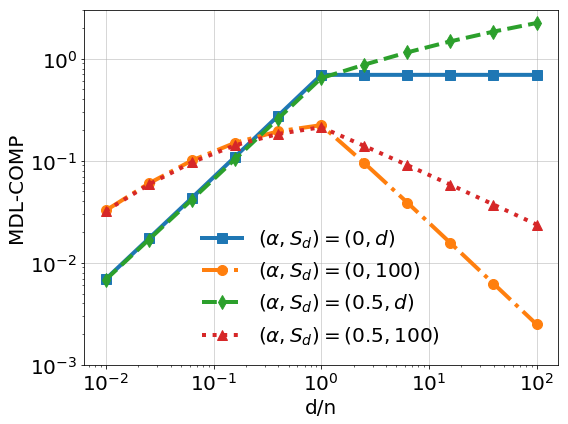

In [130]:
lss = ['-', '--', '-.', ':']
mss = ['s', 'd', 'o', '^']
plt.figure(figsize=[8, 6])
for k, epow in enumerate(epows):
    if epow==0:
        plt.loglog(gammas, thm_mdl_comp[:, k], label=r'$(\alpha, S_d)= (%d, d)$'%epow, marker=mss[k], linestyle=lss[k], linewidth=4., markersize=10)
        plt.loglog(gammas, thm_mdl_comp_2[:, k], label=r'$(\alpha, S_d)= (%d, 100)$'%epow, linestyle=lss[k+2],  marker=mss[k+2],  linewidth=4., markersize=10)
    else:
        plt.loglog(gammas, thm_mdl_comp[:, k], label=r'$(\alpha, S_d)= (%.1f, d)$'%epow, marker=mss[k], linestyle=lss[k], linewidth=4., markersize=10)
        plt.loglog(gammas, thm_mdl_comp_2[:, k], label=r'$(\alpha, S_d)= (%.1f, 100)$'%epow, linestyle=lss[k+2],  marker=mss[k+2],  linewidth=4., markersize=10)
# plt.axvline(1., color='k', alpha=0.5, linewidth=2., linestyle=':')
plt.ylabel('MDL-COMP')
plt.grid(True, alpha=0.5, linewidth=1.)
plt.ylim([1e-3, 3])
plt.legend(loc='lower center', frameon=False, fontsize=20)
plt.xlabel('d/n')
plt.tight_layout()
plt.savefig('theory_decay_mdl.pdf')
plt.show()